In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Solving the Schrodinger equation for scattering ##

We want to discuss how to solve a scattering or tunneling problem, in this case in 1D.  We will use "natural" units ($\hbar=m=1$) throughout and assume our potential, $V(x)$, is non-zero only for $0\le x\le 1$.

To begin we rewrite the "standard" (time-independent) Schrodinger equation in one dimension
$$
  -\frac{\hbar^2}{2m}\frac{d^2\Psi}{dx^2} + V(x)\Psi = E\Psi
  \quad\to\quad
  \frac{d^2\Psi}{dx^2} + k_{\rm eff}^2\Psi = 0
  \quad \mathrm{with} \quad
  k_{\rm eff}^2=2[E-V(x)]
$$
We know that
$$
  \Psi(x) = \left\{
  \begin{array}{cr} \exp[ikx]+R\exp[-ikx] & x<0 \\
  T\exp[ik(x-1)] & x>1 \end{array} \right.
$$
with $k=\sqrt{2E}$ and $R$ and $T$ the reflection and transmission _amplitudes_ (square for probabilities) obeying $|R|^2+|T|^2=1$ by probability conservation.

Our procedure is as follows: given a guess for $R$ (which is complex) we can start at $x=0$ and solve for $\Psi$ out to $x=1$.  At this point we can estimate $T$ from $\Psi(1)$ and $\Psi'(1)$ (knowing $k$).  We want the two to agree, so take their squared absolute difference as a penalty function to minimize.

One way of solving this kind of problem is with [Numerov's method](https://en.wikipedia.org/wiki/Numerov%27s_method), used in other notebooks, but in our case it's actually easier to divide the Schrodinger equation into two 1st order equations for $y=(\Psi,\Psi')$ as:
$$
  \frac{d}{dx} \left(\begin{array}{c} y_1 \\ y_2 \end{array} \right) =
  \left(\begin{array}{c} y_2 \\ -k_{\rm eff}^2 y_1 \end{array}\right)
$$
which we can solve using "standard" methods.  Part of the reason for this is we'll want to deal with sharp step-function potentials and the formulation above only requires $\Psi(0)$ and $\Psi'(0)$ at the point where $V\ne 0$ to get going, and we know both from our matching conditions (and $x<0$ solution).  The other part of this is that we can call a canned ODE integration routine from within Python and it's fast -- but if we code our own method using loops it's painfully slow.

Text(0, 0.5, '$V(x)$')

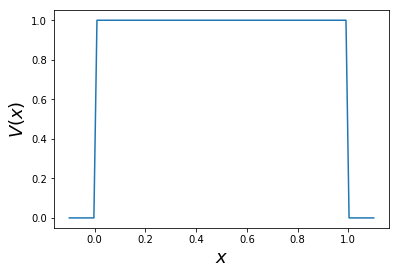

In [61]:
# Set a value of E to use:
E = 2.0
k = np.sqrt(2*E)

# Set up some "helper" functions.
def V(x):
    """Our potential -- a unit "step" running from x=0 to x=1 else zero."""
    if (x>0)&(x<1):
        return(1.0)
    else:
        return(0.0)

#
# Plot the potential, for sanity:
xx = np.linspace(-0.1,1.1,100)
vx = [V(x) for x in xx]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(xx,vx,label='$V(x)$')
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$V(x)$',fontsize=18)

In [62]:
# We use a canned ODE solver from SciPy, though "hand coding" a
# Runge-Kutta method would also work.  At this point we will also
# split Psi into real and imaginary parts.
from scipy.integrate import odeint

def derivs(x,y):
    """The derivatives defining our ODEs.  Note the order (x then y)
    indicating this uses the tfirst=True convention."""
    dy    = np.zeros_like(y)
    k2    = 2*(E-V(x))
    dy[0] =     y[2]
    dy[1] =     y[3]
    dy[2] = -k2*y[0]
    dy[3] = -k2*y[1]
    return(dy)
    #
def evolve(R):
    y    = np.zeros(4,dtype='float')
    y[0] = R.real + 1.
    y[1] = R.imag
    y[2] = R.imag*k
    y[3] = k*(1 - R.real)
    #
    xout = np.linspace(0,1,100,endpoint=True)
    ret  = odeint(derivs,y,xout,tfirst=True)
    return(ret)

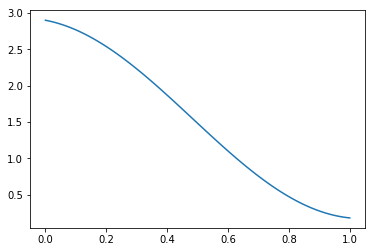

In [63]:
# Just plot the output to make sure we don't get garbage!
psi = evolve(0.7-0.1j)
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(np.linspace(0,1,100),psi[:,0]**2+psi[:,1]**2)

Now we solve for R by making two estimates of T, one from $\Psi(1)$ and one from $\Psi'(1)$, and minimizing the penalty function $|T_1-T_2|^2$:

In [64]:
def penalty(R):
    """Assuming an E has been specified, work out the penalty function that
    has to be minimized to find the right R."""
    psi = evolve(R)[-1,:]    
    T1  = (psi[0]+psi[1]*(1j))
    T2  = (psi[2]+psi[3]*(1j)) / (1j * k)
    ff  = np.abs(T1-T2)**2
    return( ff )
    #

   0.32674   -0.06000   5.9118e-04
   0.32679   -0.05750   3.6235e-04
   0.32683   -0.05500   1.8964e-04
   0.32688   -0.05250   7.3021e-05
   0.32692   -0.05000   1.2508e-05
   0.32696   -0.04750   8.0925e-06
   0.32700   -0.04500   5.9773e-05
   0.32703   -0.04250   1.6755e-04
   0.32707   -0.04000   3.3141e-04


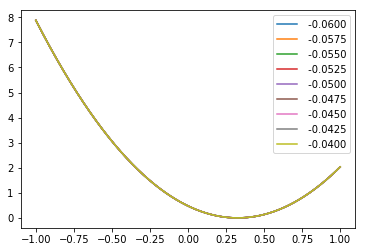

In [65]:
# Let's try to solve for R.  To begin, let's just look at how the penalty
# changes with R -- since I know where the minimum is we'll scan
# around that.
# In real life we'd pass this to a minimizer.
bP,bRr,bRi  = 1e30,None,None
fig,ax = plt.subplots(1,1,figsize=(6,4))
for Ri in np.arange(-0.06,-0.039,0.0025):
    Rr = np.linspace(-np.sqrt(1-Ri**2),np.sqrt(1-Ri**2),1000)
    dP = np.array([penalty(rr+1j*Ri) for rr in Rr])
    ax.plot(Rr,dP,label="{:8.4f}".format(Ri))
    print("{:10.5f} {:10.5f} {:12.4e}".format(Rr[np.argmin(dP)],Ri,dP[np.argmin(dP)]))
    if dP[np.argmin(dP)]<bP:
        bP  = dP[np.argmin(dP)]
        bRr = Rr[np.argmin(dP)]
        bRi = Ri
ax.legend()

R= (0.3269578526616955-0.04749999999999999j)
T= (0.14057741803912055+0.9327732547455764j) (0.1381333481851955+0.9342289301979375j)
|R|^2= 0.10915768741714699
|T|^2= 0.8898279552312016 0.8918645158996351
|R|^2+|T|^2= 0.9989856426483485


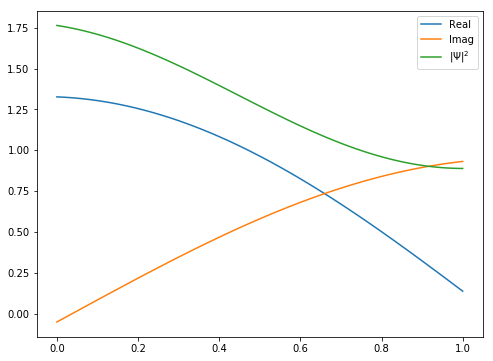

In [66]:
# Now let's look at the wavefunction for this solution.
R   = bRr + 1j*bRi
psi = evolve(R)
T1  = (psi[-1,0]+psi[-1,1]*(1j))
T2  = (psi[-1,2]+psi[-1,3]*(1j)) / (1j * k)
print("R=",R)
print("T=",T1,T2)
print("|R|^2=",np.abs(R)**2)
print("|T|^2=",np.abs(T1)**2,np.abs(T2)**2)
print("|R|^2+|T|^2=",np.abs(R)**2+np.abs(T1)**2)
#
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.linspace(0,1,100,endpoint=True),psi[:,0],label='Real')
ax.plot(np.linspace(0,1,100,endpoint=True),psi[:,1],label='Imag')
ax.plot(np.linspace(0,1,100,endpoint=True),psi[:,0]**2+psi[:,1]**2,label='$|\Psi|^2$')
ax.legend()

### Triangular barrier ###

The triangular barrier (or the triangular well) are of particular interest for studying quantum devices, including SSD drives (look up [floating gate](https://en.wikipedia.org/wiki/Flash_memory#Floating-gate_transistor) transistor and [Fowler-Nordheim](https://en.wikipedia.org/wiki/Field_electron_emission#Fowler–Nordheim_tunneling) tunneling) and a variety of interesting physical phenomena.

Let's consider a potential which switches on sharply at $x=0$ (as our step above did) but then ramps linearly to zero by $x=1$.  We'll also look at $E<V(x=0)$ so we get tunneling.

Text(0, 0.5, '$V(x)$')

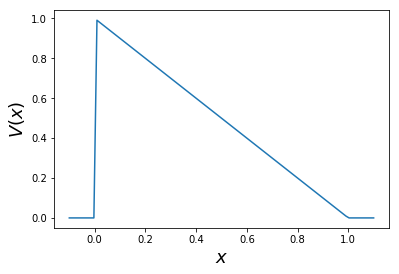

In [87]:
# Set a value of E to use:
E = 0.25
k = np.sqrt(2*E)

# Set up some "helper" functions.
def V(x):
    """Our potential -- a "triangular" step."""
    if (x>0)&(x<1):
        return(1.0-x)
    else:
        return(0.0)

#
# Plot the potential, for sanity:
xx = np.linspace(-0.1,1.1,100)
vx = [V(x) for x in xx]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(xx,vx,label='$V(x)$')
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$V(x)$',fontsize=18)

In [88]:
# Let's try to solve for R.  Now we'll use a minimizer, like
# we should have done above.  This is then a 2D problem, and
# we'll specify the real and imaginary parts as arguments to
# our penalty function.
def penalty(R):
    """Assuming an E has been specified, work out the penalty function that
    has to be minimized to find the right R (now a 2D vector)."""
    psi = evolve(R[0]+1j*R[1])[-1,:]    
    T1  = (psi[0]+psi[1]*(1j))
    T2  = (psi[2]+psi[3]*(1j)) / (1j * k)
    ff  = np.abs(T1-T2)**2
    return( ff )
    #
#
from scipy.optimize import minimize
#
res=minimize(penalty,[-0.1,0.1],method='Nelder-Mead')
R  = res.x[0] + res.x[1]*(1j)
print("Best fit R=",R)

Best fit R= (-0.12766042884522266-0.5930959349887496j)


R= (-0.12766042884522266-0.5930959349887496j)
T= (0.7948803113178599+0.015367887366614218j) (0.7947151239068668+0.015397273661301374j)
|R|^2= 0.3680599731931252
|T|^2= 0.6320708812828909 0.6318092042025077
|R|^2+|T|^2= 1.0001308544760161


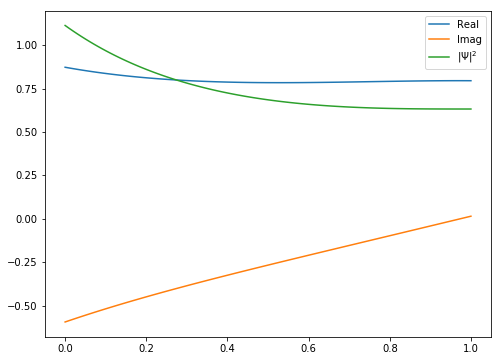

In [89]:
# Now let's look at the wavefunction for this solution.
psi = evolve(R)
T1  = (psi[-1,0]+psi[-1,1]*(1j))
T2  = (psi[-1,2]+psi[-1,3]*(1j)) / (1j * k)
print("R=",R)
print("T=",T1,T2)
print("|R|^2=",np.abs(R)**2)
print("|T|^2=",np.abs(T1)**2,np.abs(T2)**2)
print("|R|^2+|T|^2=",np.abs(R)**2+np.abs(T1)**2)
#
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.linspace(0,1,100,endpoint=True),psi[:,0],label='Real')
ax.plot(np.linspace(0,1,100,endpoint=True),psi[:,1],label='Imag')
ax.plot(np.linspace(0,1,100,endpoint=True),psi[:,0]**2+psi[:,1]**2,label='$|\Psi|^2$')
ax.legend()

So for this value of the energy ($E=0.25$) about 63% of the probability goes through the step while the other 37% reflects.